# Topic Modeling
In order to cluster our documents, we used the unsupervised topic modeling technique of LDA. With topic modeling we hope to discover the categories that the topics are clustered into and use this structure to summarize/organize the documents.

# LDA (Latent Dirichlet Allocation)
 It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. This model was chosen due to the following advantages of LDA over its common counter part, non-negative matrix factorization.
1. Assumes each document has multiple topics.
2. Works best with longer texts such as full articles, essays, and books.
3. Evolves as you process new documents with the same model.
4. Results are not deterministic, meaning you might get different results each time for the same data set.

In particular, on the world bank's webpage, we have that there are 11 categories of loans. Some loans are wide ranging social programs that can have effects in more than one of these categories. LDA will be better to capture this multi-topic property of the loans. Additionally, the project descriptions (580 words on average) can be relatively long compared to say a tweet (280 words on average), so LDA should handle it better. The non-deterministic nature of the algorithm

## Assumptions for LDA
The following assumptions are necessary in order for this algorithm to be used:
1. The semantic content of a document is composed by combining one or more terms from one or more topics.
2. Certain terms are ambiguous, belonging to more than one topic, with different probability. However, in a document, the accompanying presence of specific neighboring terms (which belong to only one topic) will disambiguate their usage.
3. Most documents will contain only a relatively small number of topics. In the collection, individual topics will occur with differing frequencies. That is, they have a probability distribution, so that a given document is more likely to contain some topics than others.
4. Within a topic, certain terms will be used much more frequently than others. In other words, the terms within a topic will also have their own probability distribution.


In [2]:
from itertools import *
import numpy as np
import pandas as pd
from collections import Counter
import re
import os
import sys

from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  


import string
import nltk
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
words = set(nltk.corpus.words.words())
#!{sys.executable} -m pip install spacy
from stop_words import get_stop_words
import spacy
from gensim import corpora, models
from gensim.corpora import Dictionary
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

from sklearn.metrics import silhouette_score

import pyLDAvis
import pyLDAvis.gensim_models

[nltk_data] Downloading package stopwords to /home/kbari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kbari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Extract project descriptions from each document
Currently extracts 2941/3205 project descriptions (91%)

In [3]:
## Path to text files
path = "/home/kbari/git_repo/FinanceErdosProj/PyMuPdf_Text/"
path1 = "/home/kbari/git_repo/FinanceErdosProj/Tesseract_Text/"

## Load from txt from files to a dataframe; Other information to include possibly?

#pd.read_table(file,header=None,quotechar=None,quoting=3,error_bad_lines=False) for file in DIR]
def txt_to_df(path):
    ''' Put all txt files into single dataframe'''
    DIR = os.listdir(path)
    raw_df_lst = []
    for i in range(len(DIR)):
        with open(path+DIR[i],encoding = "ISO-8859-1") as f:
            lines = f.readlines()
            data = '\n'.join(map(str,lines))
            #print(DIR[i])
            p = proj_desc_preprocess(data)
            if p is not None:
                p = p.replace("\n","")
                l = len(p)
            else:
                l = 0
            try:
                c = proj_name_preprocess(data)
                n = int(len(c))
            except:
                c = None
                n = int(0)
            di= pd.DataFrame([data,p,c],index=['raw_text','proj_desc','proj_name'],columns=[DIR[i]]).T
            raw_df_lst.append(di)
    #print(len(raw_df_lst))
    df_raw = pd.concat(raw_df_lst)
    return df_raw

## Grab Project Description   
def proj_desc_preprocess(text):
    ''' Grab Project Description'''
    if len(re.findall('Project Description',text,re.IGNORECASE)) > 0:
        start = 'Project Description'
        end = 'SCHEDULE'
        try:
            return text.split(start)[1].split(end)[0]
        except:
            return None
    elif len(re.findall('Description of the Project',text,re.IGNORECASE)) > 0:
        start = 'Description of the Project'
        end = 'SCHEDULE'
        try:
            return text.split(start)[1].split(end)[0]
        except:
            return None
    elif len(re.findall('Program Actions',text,re.IGNORECASE)) > 0:
        start = 'Program Actions'
        end = 'Section II'
        try:
            return text.split(start)[1].split(end)[0]
        except:
            return None
    elif len(re.findall('Schedule 3',text,re.IGNORECASE)) > 0:
        start = 'SCHEDULE 3'
        #end = 'SCHEDULE 3'
        try:
            return text.split(start)[1]
        except:
            return None
    elif len(re.findall('Schedule III',text,re.IGNORECASE)) > 0:
        start = 'SCHEDULE III'
        #end = 'SCHEDULE 3'
        try:
            return text.split(start)[1]
        except:
            return None
    else:
        #print('CASE 4')
        return None
    
## Grab Project Name   
def proj_name_preprocess(text):
    start = 'agreement'
    start1 = 'number'
    end = 'between'
    end1 = 'among'
    t = text.lower().split(start)[1].split(end)[0].strip()
    s = text.lower().split(start1)[1].split(end)[0].strip()
    r = text.lower().split(start)[1].split(end1)[0].strip()
    if 'date' in t:
        if 'date' in s:
            if 'date' in r:
                return None
            else:
                return r
        else:
            return s
    else:
        return t



df = txt_to_df(path)
df1 = txt_to_df(path1)
dF = pd.concat([df,df1])
dF.fillna('',inplace=True)
dF['corp'] = dF[['proj_name', 'proj_desc']].agg(' '.join, axis=1)
## Drop null proj desc/proj_name
dG = dF[dF['corp'].map(len)!=0]
dG.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3205 entries, 2006_july_4_213051468296429321_loan-agreement-l4825-ro-conformed.txt to 2019_april_2_393831555439741186_official-documents-loan-agreement-for-loan-8932-ph-closing-package.txt
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   raw_text   3205 non-null   object
 1   proj_desc  3205 non-null   object
 2   proj_name  3205 non-null   object
 3   corp       3205 non-null   object
dtypes: object(4)
memory usage: 125.2+ KB


### Explore project description lengths and distribution of the numbers of words in each project description

In [4]:
document_lengths = np.array(list(map(len, dG.corp.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 538.5753510140405.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 6604.


/home/kbari/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


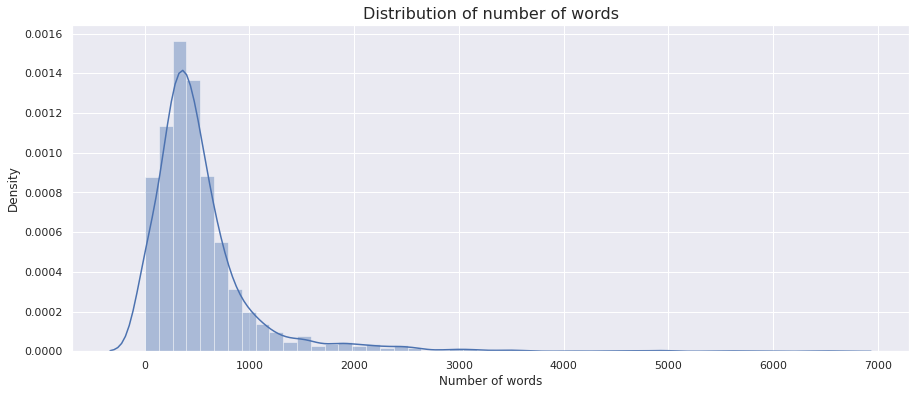

In [5]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

### Function to tokenize/lemmatize texts in unigrams. 
Removes certain words that are common and do not help distinguish clusters. Additionally removes punctuation, numeric terms, non-english terms, non-english characters then lemmatizes.

In [6]:
## Common words to remove from dictionary
W = ['work','research','quality','information','national','design','related','access','assist','service','use','within','good','project','policy','equipment','principal','technical','capacity','training','assistance','support','program','sector','improvement','amount','amortization','due','and','account','achieve','assistance','respect','strengthen','strengthening','improve','inter','selected','new','thereof','withdrawal','withdrawn','subject','plan','taken','least','schedule','carrying','following','agree','upon','said','part','made','paragraph','implementation','borrower','date','january','february','march','april','may','june','july','august','september','october','november','december','for','management','section','id','the','payment','objective','provision','bank','system','time','loan','development','shall','set','forth','agreement','general','down']

#'project','policy','equipment','principal','technical','capacity','training','assistance','support','program','sector','improvement','amount',
def text_preprocess(text):
    '''
    Remove all punctuation,stopwords, non-english words, numbers, lemmatize -> returns list of words
    '''
    stemmer = WordNetLemmatizer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc =  [word for word in nopunc.split() if word.isalnum()]
    nopunc =  [word.lower() for word in nopunc if word not in stopwords.words('english')]
    nopunc =  [word for word in nopunc if len(word)>2]
    nopunc = [word for word in nopunc if word not in W]
    nopunc = [w for w in nopunc if w.lower() in words or not w.isalpha()]
    return [stemmer.lemmatize(word) for word in nopunc]

### Bigram version of function 
Refer to Bigram notebook for that implementation

In [7]:
def text_preprocess_2(text):
    '''
    Remove all punctuation,stopwords, non-english words, numbers, lemmatize -> returns list of words
    '''
    bigrm = nltk.bigrams(text_preprocess(text))
    B = ['_'.join(b) for b in bigrm]
    return B

In [8]:
docLabels= dG.index
data = dG.corp

### Example to see how processing performs

In [8]:
#i = 0
#print(data[i])
#print(text_preprocess(data[i]))
#print(text_preprocess_2(data[i]))

### Add column of processed text 
This returns a column called stem which contains a list of relevant words from each document

In [9]:
## Add column of processed texts
def lem_stem(df):
    df['stem'] = list(map(lambda sentence: text_preprocess(sentence),df.corp))
    return
    
def lem_stem2(df):
    df['stem'] = list(map(lambda sentence: text_preprocess_2(sentence),df.corp))
    return

In [10]:
%%time
## lem_stem for words or lem_stem2 for bigrams
lem_stem(dG)

CPU times: user 3min 16s, sys: 16.3 s, total: 3min 32s
Wall time: 3min 32s


### Word frequency

Here we show the most common words in all the documents. This was used to help remove common words that will not help separate documents by topic. For example "loan" and "project" appeared in nearly all of them and so those words were removed.

/home/kbari/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


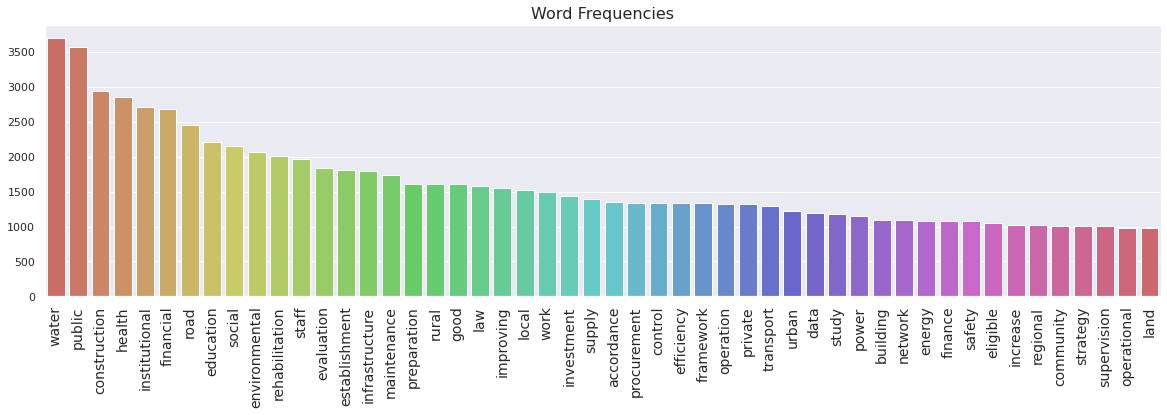

In [11]:
token_dict = Counter(np.concatenate(dG.stem.values))

token_df = pd.DataFrame.from_dict(token_dict, orient='index')
token_df.rename(columns={0: 'count'}, inplace=True)
token_df.sort_values('count', ascending=False, inplace=True)

def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(token_df)
ax.set_title("Word Frequencies", fontsize=16);

In [12]:
dictionary = Dictionary(documents=dG.stem.values)

print("Found {} words.".format(len(dictionary.values())))

Found 7533 words.


In [13]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify() 
print("Left with {} words.".format(len(dictionary.values())))

Left with 4286 words.


### Creates column for bag of words to run LDA 
This converts the words to numeric values that LDA can interpret. This uses the doc2bow function which takes the list of words to bag of words

In [14]:
# Bag of Words for each lemmatized document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stem))
    
document_to_bow(dG)
corpus = dG.bow

## Hyperparameter tuning
Takes approximately one hour to run. The parameters used were number of topics (k), alpha representing document-topic density (a), and eta representing topic-word density (b).

Uncomment second cell to run hyperparameter tuning

In [15]:
# Hyperparameter Tuning
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=4000,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=dG.stem.values.tolist(), dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [16]:
# %%time
# #import tqdm

# min_topics = 5
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
# model_results = {'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

# for k in topics_range:
#     for a in alpha:
#         for b in beta:
#             #print(k,a,b)
#             cv = compute_coherence_values(corpus=corpus, dictionary=dictionary, 
#                                           k=k, a=a, b=b)
#             #print(cv)
#             model_results['Topics'].append(k)
#             model_results['Alpha'].append(a)
#             model_results['Beta'].append(b)
#             model_results['Coherence'].append(cv)

# #dr = pd.DataFrame(model_results)


Use best parameters

In [17]:
# m = max(model_results['Coherence'])
# idx = model_results['Coherence'].index(m)
# num_topics = model_results['Topics'][idx] #7
# a = model_results['Alpha'][idx] #asymmetric
# b = model_results['Beta'][idx] #0.9099999999999999
# print(model_results['Coherence'][idx]) #0.6152337530122866

## Train LDA Model
 Trains LDA model and then saves it. Change third cell to save or load model

In [16]:
corpus = dG.bow

In [17]:
%%time
#LDA multicore approach
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        #workers=4,
                        chunksize=4000,
                        passes=10,
                        alpha=a,
                        eta=b)

CPU times: user 42.8 s, sys: 19.1 s, total: 1min 1s
Wall time: 1min 1s


Save model or load already trained version

In [18]:
## SAVE MODEL
#LDAmodel.save('lda.model')
## LOAD MODEL
LDAmodel = LDAmodel.load('lda.model')

Prints out LDA topics with top 10 words in each topic

In [19]:
LDAmodel.print_topics()

[(0,
  '0.035*"health" + 0.027*"education" + 0.015*"social" + 0.012*"public" + 0.012*"evaluation" + 0.011*"care" + 0.009*"school" + 0.009*"community" + 0.009*"rural" + 0.008*"institutional"'),
 (1,
  '0.016*"financial" + 0.014*"public" + 0.011*"institutional" + 0.009*"private" + 0.009*"establishment" + 0.008*"investment" + 0.008*"infrastructure" + 0.008*"business" + 0.008*"staff" + 0.007*"agricultural"'),
 (2,
  '0.024*"law" + 0.015*"public" + 0.014*"water" + 0.013*"official" + 0.012*"gazette" + 0.010*"decree" + 0.009*"budget" + 0.008*"framework" + 0.008*"financial" + 0.008*"satisfactory"'),
 (3,
  '0.013*"currency" + 0.011*"proceeds" + 0.010*"year" + 0.009*"table" + 0.009*"first" + 0.009*"accordance" + 0.009*"conversion" + 0.008*"rate" + 0.008*"installment" + 0.008*"repayable"'),
 (4,
  '0.019*"accordance" + 0.018*"special" + 0.017*"contract" + 0.015*"good" + 0.015*"procurement" + 0.012*"request" + 0.012*"eligible" + 0.011*"pursuant" + 0.011*"basis" + 0.011*"evidence"'),
 (5,
  '0.019

In [20]:
# Compute Perplexity
print('\nPerplexity: ', LDAmodel.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=LDAmodel, texts=dG.stem.values.tolist(), dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.717952133922491

Coherence Score:  0.5862358243345002


## Visualize output of model
Adjusting lambda to values close to 0 highlights potentially rare but more exclusive terms for the selected topic. Larger lambda values (closer to 1) highlight more frequently occurring terms in the document that might not be exclusive to the topic. 
http://www.kennyshirley.com/LDAvis/

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(LDAmodel, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda.html')
vis

/home/kbari/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.144007 -0.063880       1        1  26.928395
1      0.080686  0.022008       2        1  18.651693
0      0.100010  0.053580       3        1  18.098101
2     -0.022725 -0.063169       4        1  12.210580
4     -0.213709  0.083266       5        1   9.230841
3     -0.157694 -0.090842       6        1   8.865230
5      0.069425  0.059037       7        1   6.015161, topic_info=            Term         Freq        Total Category  logprob  loglift
309       health  2576.000000  2576.000000  Default  30.0000  30.0000
18     education  2006.000000  2006.000000  Default  29.0000  29.0000
383        water  3621.000000  3621.000000  Default  28.0000  28.0000
813         road  2431.000000  2431.000000  Default  27.0000  27.0000
243          law  1419.000000  1419.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
23    evaluation    92.282561  1709.687584   Topic7  -5.4816  -0.1083
162        legal    81.712068   738.237287   Topic7  -5.6033   0.6098
195   collection    79.212801   692.860577   Topic7  -5.6343   0.6422
52   preparation    84.875408  1551.511062   Topic7  -5.5653  -0.0949
388   protection    78.673933   716.140557   Topic7  -5.6411   0.6023

[470 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1203      1  0.013447  academic
1203      2  0.026893  academic
1203      3  0.860589  academic
1203      4  0.053787  academic
1203      5  0.013447  academic
...     ...       ...       ...
77        3  0.834357     youth
77        4  0.008344     youth
77        5  0.008344     youth
77        6  0.016687     youth
77        7  0.008344     youth

[2744 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 1, 3, 5, 4, 6])

## Topics in Diagram (Topics as provided by LDA model)
0. Education/Social Protection
1. Financial Sector/ Industry,Trade and Services/ Energy
2. Public Admin/ Info and Communication
3. Financial Sector
4. Industry,Trade and Services/ Info and Communication
5. Agricultural/ Conservation
6. Energy/Transportation/Sanit


## Topics from World Bank
1. Agriculture
2. Education
3. Energy & Extractives
4. Financial Sector
5. Health
6. Industry, Trade and Services
7. Info and Communication
8. Public Admin
9. Social Protection
10. Transportation
11. Water/Sanit/Waste

## Predict Topics for Document

In [ ]:
def lda_predict(doc,model):
    ''' Displays distribution of topics within corpus document'''
    s = text_preprocess(doc)
    b = list(dictionary.doc2bow(s))
    p = list(model[b])
    topics = sorted(p,key=lambda x:x[1],reverse=True)
    return topics

#i = 2
#print(data[i])
#p = lda_predict(data[i],LDAmodel)
#print(text_preprocess(data[i]))
#print(p)

## Create Sector CSV file
Takes tppic/cluster with largest probability

In [25]:
def add_sector(df):
    df['sector'] = [lda_predict(f,LDAmodel)[0][0] for f in df.corp]

In [26]:
%%time
add_sector(dG)

CPU times: user 2min 5s, sys: 9.8 s, total: 2min 15s
Wall time: 2min 14s


In [27]:
dG.sector.head()
dG.sector.to_csv('lda_sector.csv') 

### See the number of elements in each cluster

In [28]:
num = [len(dG[dG['sector'] == s]) for s in dG.sector.unique()]
print(num)

[626, 688, 179, 376, 1101, 119, 116]


### Checking consistency of topics by randomly looking at several documents in each sector

In [58]:
# sector
sect = 3
# element number
i = 2
dt = dG[dG['sector'] == sect]
print(dt.corp[i][:1000])
p = lda_predict(dt.corp[i],LDAmodel)
print(text_preprocess(dt.corp[i])[:500])
print(p)

(energy efficiency scale-up program) Commitment-Linked Amortization Repayment ScheduleThe following table sets forth the Principal Payment Dates of the Loan and the percentageof the total principal amount of the Loan payable on each Principal Payment Date("Installment Share").Level Principal Repayments'Principal Payment Date Installment ShareOn each May 15 and November 15Beginning May 15, 2023through May 15, 2036 3.57%On November 15, 2036 3.61%' The determination of the principal amounts of the Loan repayable on each Principal PaymentDate is made in accordance with Section 3.03 of the General Conditions.- 17-SCHEDULE 4PROGRAM ACTION PLANThe Program Action Plan includes institutional strengthening actions to ensure that theBorrower is well equipped to deliver activities and achieve results under the Program.Action Description and Due Date1. The Borrower shall, no later than March 31, 2019:o Update the Borrower's Guidelines, Policy and Procedure for Procurement ofGoods, Works and Non-Con

## Save topic distribution to CSV

In [30]:
def sector_distr(f):
    p = lda_predict(f,LDAmodel)
    idx = [k[0] for k in p]
    val = [k[1] for k in p]
    return [val[idx.index(i)] if i in idx else 0 for i in range(num_topics)]

def sector_distr_all(df):
    dg = pd.DataFrame([sector_distr(f) for f in df.corp])
    dg.index = df.index
    return dg

In [31]:
%%time
dg = sector_distr_all(dG)
dg.fillna(0,inplace=True)
dg.to_csv('lda_sect_distr.csv') 

CPU times: user 2min 6s, sys: 10.2 s, total: 2min 16s
Wall time: 2min 16s


## Silhouette Coefficient

The silhouette coefficient is another measure of how well the clustering performed. The values range from -1 to 1 with 1 being well distinguished clusters and 0 being clusters that are not as distinguishable and -1 begin that the clusters are egregiously wrong. This coefficient was computed by treating the distribution as a 7 dimensional vector for each document and then computing the silhouetter score on the set of these vectors.

In [32]:
silhouette_score(dg,dG.sector) #0.6930549913516015 for trained model

0.6930549913516015